In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.argv=['']
del sys
os.chdir("../")

In [2]:
import matplotlib.pyplot as plt
import os
import json
import math
import torch
import numpy
import pandas
import logging

from IPython import embed
from common import data_preprocess 
from common.utils import print_to_json
from common.dataloader import load_SMAP_MSL_dataset, load_CSV_dataset
from common.sliding import BatchSlidingWindow, WindowIterator
from common.config import parse_arguments, set_logger, initialize_config
from networks.mlstm import MultiLSTMEncoder


args = parse_arguments()

%matplotlib inline

In [15]:
import os
import json
import math
import torch
import numpy
import pandas
import logging
import pandas as pd
import numpy as np
from IPython import embed
from common import data_preprocess 
from common.utils import print_to_json
from common.dataloader import load_SMAP_MSL_dataset, load_CSV_dataset, load_SMD_dataset
from common.sliding import BatchSlidingWindow, WindowIterator
from common.config import parse_arguments, set_logger, initialize_config
from networks.mlstm import MultiLSTMEncoder

args = parse_arguments()
# args["load"] = "./checkpoints/20201120-161839"
args["clear"] = 1

# load config
config_dir = "./hypers/" if not args["load"] else args["load"]
params = initialize_config(config_dir, args)
params["nrows"] = 3000

# load & preprocess data
data_dict = load_SMD_dataset("./datasets/anomaly/SMD/SMD/processed", "machine-1-1")
pp = data_preprocess.preprocessor()
if params["discretized"]:
    data_dict = pp.discretize(data_dict)
    vocab_size = pp.build_vocab(data_dict)
if params["normalize"]:
    data_dict = pp.normalize(data_dict, method=params["normalize"])
pp.save(params["save_path"])

window_dict = data_preprocess.generate_windows(data_dict, data_hdf5_path=params["path"], **params)

train_iterator = WindowIterator(window_dict["train_windows"], batch_size=params["batch_size"], shuffle=True)
test_iterator = WindowIterator(window_dict["test_windows"], batch_size=params["batch_size"], shuffle=False)
params['in_channels'] = data_dict["dim"]

logging.info("Proceeding using {}...".format(params["device"]))
logging.info(print_to_json(params))

2020-11-30 15:19:00,580 P80626 INFO Loading machine-1-1 dataset
2020-11-30 15:19:00,592 P80626 INFO Saving preprocessor into ./checkpoints/20201130-151900/preprocessor.pkl
2020-11-30 15:19:00,594 P80626 INFO Generating sliding windows (size 128) for dataset [machine-1-1]
2020-11-30 15:19:03,949 P80626 INFO Saving hdf5 to ./datasets/anomaly/SMAP-MSL/hdf5/window_dict_ws=128_nrows=3000.hdf5
2020-11-30 15:19:04,051 P80626 INFO Proceeding using cpu...
2020-11-30 15:19:04,052 P80626 INFO {
    "batch_size": "64",
    "clear": "1",
    "compared_length": "None",
    "dataset": "SMAP",
    "device": "cpu",
    "discretized": "False",
    "expid": "mlstm",
    "gpu": "0",
    "hidden_size": "128",
    "in_channels": "38",
    "load": "",
    "lr": "0.001",
    "nb_random_samples": "5",
    "nb_steps": "2000",
    "nb_steps_per_verbose": "2000",
    "negative_penalty": "1",
    "normalize": "False",
    "nrows": "3000",
    "num_layers": "2",
    "path": "./datasets/anomaly/SMAP-MSL",
    "penal

In [22]:
for col in data_dict["machine-1-1"]["train"].T:
    print(col.max(), col.min())

0.494624 0.0
0.42161 0.0
0.278707 0.0
0.250871 0.0
0.0 0.0
1.0 0.0
0.36064 0.0
0.0 0.0
0.118081 0.0
0.140435 0.0
1.0 0.0
0.743243 0.0
0.315068 0.0
0.123057 0.003811
0.565002 0.0
1.0 0.018205
0.0 0.0
0.0 0.0
0.298039 0.015894
0.369534 0.010018
0.355719 0.010721
0.299226 0.006325
1.0 0.0
0.033494 0.0
0.17964 0.0
0.031376 0.0
0.0 0.0
0.297707 0.008964
0.0 0.0
0.028653 0.0
0.275407 0.006146
0.303139 0.006691
0.002318 0.0
0.001271 0.0
0.311229 0.00876
0.311206 0.008759
0.0 0.0
0.0 0.0


In [16]:
# training
encoder = MultiLSTMEncoder(**params)

if params["load"]:
    encoder.load_encoder()
else:
    encoder.fit(
            train_iterator,
            test_iterator=test_iterator.loader,
            test_labels=window_dict["test_labels"],
            **params
        )
return_dict = encoder.score(test_iterator.loader, window_dict["test_labels"])

2020-11-30 15:19:29,165 P80626 INFO Compiling finished.
2020-11-30 15:19:29,167 P80626 INFO Start training for 2000 steps.
2020-11-30 15:19:29,168 P80626 INFO Epoch: 1
2020-11-30 15:19:45,430 P80626 INFO Epoch: 1, loss: 0.006
2020-11-30 15:19:45,436 P80626 INFO Evaluating 
2020-11-30 15:19:50,161 P80626 INFO Threshold for 88 percent is: 0.01
/Users/liujinyang/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/liujinyang/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
2020-11-30 15:19:50,186 P80626 INFO F1: 0.000, PS: 0.000, RC:0.000
2020-11-30 15:19:50,187 P80626 INFO Saving model to ./checkpoints/20201130-1519

KeyboardInterrupt: 

In [17]:
pred_score = pd.Series(return_dict["diff_list"].cpu().numpy())

NameError: name 'return_dict' is not defined

In [18]:
pred_index = np.where(return_dict["pred"] == True)[0]
print("Prediction anomaly number: {}/{}".format(len(pred_index), len(return_dict["pred"])))

NameError: name 'return_dict' is not defined

In [12]:
anomaly_index = np.where(return_dict["anomaly_label"] == 1)[0]
print("Actual anomaly number: {}/{}".format(len(anomaly_index), len(return_dict["pred"])))

Actual anomaly number: 54696/427598


In [43]:
hit_index = np.where(return_dict["anomaly_label"]== return_dict["pred"].astype(int))[0]
print("Hit anomaly number: {}/{}".format(len(hit_index), len(return_dict["pred"])))

Hit anomaly number: 370738/427598


In [47]:
list(set(hit_index) & set(anomaly_index))[0:20]  

[131072,
 131073,
 131074,
 131075,
 131076,
 131077,
 131078,
 131079,
 131080,
 131081,
 131082,
 131083,
 131084,
 131085,
 131086,
 131087,
 131088,
 131089,
 131090,
 131091]

In [59]:
anomaly_index[24000: 26300]

array([123624, 123625, 123626, ..., 131285, 131286, 131287])

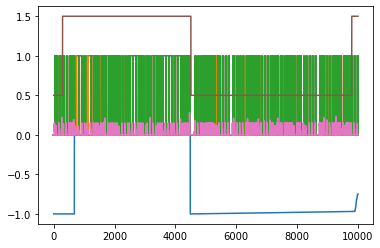

In [60]:
start = 111000
steps = 10000
p = plt.plot(data_dict["SMAP"]["test"][start: start+steps])
p = plt.plot(return_dict["anomaly_label"][start: start+steps] + 0.5)
p = plt.plot(pred_score[start: start+steps].reset_index(drop=True))

0      0.004676
1      0.003799
2      0.002447
3      0.001885
4      0.001229
         ...   
295    0.029094
296    0.019666
297    0.070605
298    0.002637
299    0.002460
Length: 300, dtype: float32

In [22]:
data_dict["SMAP"]["test"].shape

(427617, 25)

In [7]:
plt.plot(window_dict["test_windows"][0])

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.

In [8]:
pred_score.hist()

NameError: name 'pred_score' is not defined